In [16]:
#module Duals
#export Dual
# porównanie funkcji ze stabilnymi źródłami

import Base: +, -, *, /
import Base: abs, sin, cos, tan, exp, sqrt, isless
import Base: convert, promote_rule
import Base: show,sum

struct Dual{T <:Number} <:Number
    v::T
    dv::T
end

-(x::Dual) = Dual(-x.v, -x.dv)
+(x::Dual, y::Dual) = Dual(x.v + y.v , x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v, x.dv - y.dv)
*(x::Dual, y::Dual) = Dual(x.v * y.v, x.dv * y.v + x.v * y.dv)

/(z::Dual, w::Dual) = Dual(value(z)/value(w), (partials(z)*value(w)-value(z)*partials(w))/(value(w)*value(w)))

# /(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

abs(x::Dual) = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual) = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual) = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual) = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
#exp(x::Dual) = Dual(exp(x.v), exp(x.v)*x.dv)
Base.exp(z::Dual) = (expval = exp(value(z)); Dual(expval, partials(z)*expval))
sqrt(x::Dual) = Dual(sqrt(x.v),0.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;
sum(x::Array{Dual{Float64},1}) = Dual(sum((p ->p.v).(x)), sum((p ->p.dv).(x)) )

convert(::Type{Dual{T}}, x::Dual) where T =
 Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T =
 Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} =
 Dual{promote_type(T,R)}

show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]\n");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

#end

# Plots import

In [ ]:
import Pkg

In [ ]:
Pkg.add("Plots")

In [3]:
using Plots

# BenchmarkTools Import

In [ ]:
Pkg.add("BenchmarkTools")

In [4]:
using BenchmarkTools

# ReLu

In [ ]:
ReLu(x::Dual) = x > zero(x) ? x : zero(x)

In [ ]:
ϵ = Dual(0., 1.) # zarodek, ang. seed
x = -1.0:0.05:+1.0
y = @. ReLu(x + ϵ)

In [ ]:
plot(x, (p->p.dv).(y), label = "partials")
plot!(x, (p->p.v).(y), label = "value")

In [ ]:
@benchmark @. ReLu(x + ϵ)

In [ ]:
@benchmark @. ReLu(x + ϵ)

# Softmax

In [21]:
softmax(arg::Array{Dual{Float64}}) = exp.(arg) ./ sum(exp.(arg));

A = collect(-10.0:0.1:10.0)

    output = []
    ϵ = Dual(0., 1.)

    for i in 1:1:length(A)
        list = convert(Array{Dual{Float64}}, deepcopy(A))
        # display(list)
        list[i] = list[i] + ϵ
    
        append!(output, softmax(list)[i])
     end
    
    display("output")
    display(output)

201

"output"

201-element Array{Any,1}:
    (1.961447009015997e-10) + [1.96144700863127e-10ϵ]

  (2.167734191710942e-10) + [2.1677341912410347e-10ϵ]

 (2.3957167867971533e-10) + [2.3957167862232073e-10ϵ]

 (2.6476765207138535e-10) + [2.6476765200128344e-10ϵ]

 (2.9261350911646653e-10) + [2.9261350903084387e-10ϵ]

 (3.2338794051158214e-10) + [3.2338794040700236e-10ϵ]

  (3.5739894710977795e-10) + [3.573989469820439e-10ϵ]

 (3.9498692249658296e-10) + [3.9498692234056827e-10ϵ]

   (4.365280597634239e-10) + [4.365280595728672e-10ϵ]

   (4.824381165745243e-10) + [4.824381163417777e-10ϵ]

   (5.331765762093531e-10) + [5.331765759250758e-10ϵ]

    (5.892512462257211e-10) + [5.89251245878504e-10ϵ]

   (6.512233407684994e-10) + [6.512233403444077e-10ϵ]

                                                     ⋮
      (0.03167687184495512) + [0.030673447635073407ϵ]

     (0.035008357538653674) + [0.033782772441099465ϵ]

       (0.03869021864131438) + [0.03719328562280167ϵ]

       (0.04275930445636894) + [0.04093

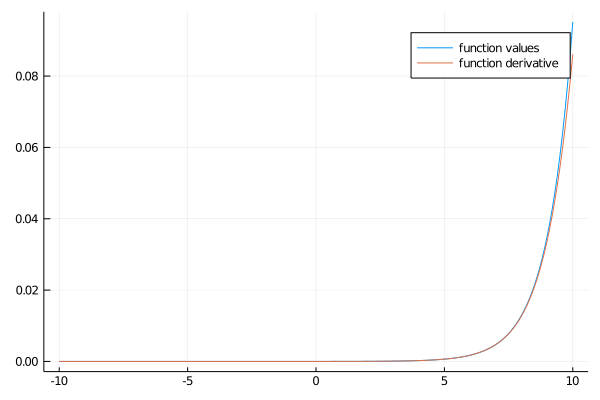

In [14]:
plot(A, (x->x.v).(output), label = "function values")
display(plot!(A, (x->x.dv).(output), label = "function derivative"))

In [ ]:
typeof(soft_dual)
s= size(soft_dual)
plot(collect(1:s[1]), (p->p.v).(soft_dual), label = "value")
plot!(collect(1:s[1]), (p->p.dv).(soft_dual), label = "partial")

In [ ]:
@benchmark softmax(x .+ ϵ)

# Sin

In [ ]:
range =  0:π/360:2*π
sinus = [sin(Dual(x,1.0)) for x in range]
@benchmark [sin(Dual(x,1.0)) for x in range]

In [ ]:
plot(range, (x->x.v).(sinus), label = "sinus Dual.value")
plot!(range, (x->x.dv).(sinus), label = "sinus Dual.particle")

# Cos

In [ ]:
range =  0:π/360:2*π
cosinus = [cos(Dual(x,1.0)) for x in range]
@benchmark [cos(Dual(x,1.0)) for x in range]

In [ ]:
plot(range, (x->x.v).(cosinus), label = "cosinus Dual.value")
plot!(range, (x->x.dv).(cosinus), label = "cosinus Dual.particle")

# Tan

In [ ]:
range =  -π/2+π/180:π/180:π/2- π/180
# range = -1.2:0.001:1.2
tang = [tan(Dual(x,1.0)) for x in range]
@benchmark [tan(Dual(x,1.0)) for x in range]

In [ ]:
plot(range, (x->x.v).(tang), label = "tangens Dual.value")
plot!(range, (x->x.dv).(tang), label = "tangens Dual.particle")

# Rosenbrock

In [ ]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x)
v = -1:.2:+1
n = length(v)
ϵ = Dual(0., 1.)
xv = repeat(v, inner=n)
yv = repeat(v, outer=n)

z = rosenbrock.(xv .+ ϵ, yv)
dx = 5e-4partials.(z)
z = rosenbrock.(xv, yv .+ ϵ)
dy = 5e-4partials.(z)
zv = value.(z)

using Plots
zv = reshape(zv, n, n)
contour(v, v, zv, fill=true)
quiver!(xv[:], yv[:], gradient=(dx, dy))

In [ ]:
@benchmark @. rosenbrock(xv + ϵ, yv)

In [ ]:
@benchmark @. rosenbrock(xv + ϵ, yv)

In [ ]:
@benchmark @. rosenbrock(xv + ϵ, yv + ϵ)

# Jacobi matrix

In [17]:
J = function jacobian(f::Function, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:length(args)
    x = Dual{T}[]
    for j=1:length(args)
    seed = (i == j)
    push!(x, seed ?
    Dual(args[j], one(args[j])) :
    Dual(args[j],zero(args[j])) )
    end
    column = partials.([f(x)...])
    push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

## Test data

In [18]:
x= [i for i in 1:0.5:10];
range = [i for i in 0:π/360:2*π] ;
rangeTan = [i for i in -π/2+π/180:π/180:π/2- π/180] ;

## Jacobi - ReLU

In [ ]:
ReLu(x) = x > zero(x) ? x : zero(x)

In [ ]:
y = J(ReLu,x);

In [ ]:
@benchmark J(ReLu,x)

## Jacobi - SoftMax

In [19]:
y = J(softmax,x)

19×19 Array{Float64,2}:
  4.85593e-5  -3.88806e-9  -6.41033e-9   …  -1.15902e-5   -1.91089e-5
 -3.88806e-9   8.00581e-5  -1.05689e-8      -1.91089e-5   -3.15053e-5
 -6.41033e-9  -1.05689e-8   0.000131987     -3.15053e-5   -5.19435e-5
 -1.05689e-8  -1.74251e-8  -2.87291e-8      -5.19435e-5   -8.56403e-5
 -1.74251e-8  -2.87291e-8  -4.73663e-8      -8.56403e-5   -0.000141197
 -2.87291e-8  -4.73663e-8  -7.80938e-8   …  -0.000141197  -0.000232794
 -4.73663e-8  -7.80938e-8  -1.28755e-7      -0.000232794  -0.000383813
 -7.80938e-8  -1.28755e-7  -2.12281e-7      -0.000383813  -0.000632801
 -1.28755e-7  -2.12281e-7  -3.49992e-7      -0.000632801  -0.00104331
 -2.12281e-7  -3.49992e-7  -5.7704e-7       -0.00104331   -0.00172013
 -3.49992e-7  -5.7704e-7   -9.51378e-7   …  -0.00172013   -0.00283602
 -5.7704e-7   -9.51378e-7  -1.56856e-6      -0.00283602   -0.0046758
 -9.51378e-7  -1.56856e-6  -2.58611e-6      -0.0046758    -0.00770909
 -1.56856e-6  -2.58611e-6  -4.26378e-6      -0.00770909   -0.01

In [ ]:
@benchmark J(softmax,x)

## Jacobi - Sin

In [ ]:
y = J(x -> sin.(x), range);

In [ ]:
@benchmark J(x -> sin.(x), range)

## Jacobi - Cos

In [ ]:
y = J(x -> cos.(x), range);

In [ ]:
@benchmark J(x -> cos.(x), range)

## Jacobi - Tan

In [ ]:
y = J(x -> tan.(x), rangeTan);

In [ ]:
@benchmark J(x -> tan.(x), range)